In [1]:
import pandas as pd

data = {
    'Institution': ['Inst_1', 'Inst_2', 'Inst_3', 'Inst_4', 'Inst_5', 'Inst_6', 'Inst_7', 'Inst_8', 'Inst_9', 'Inst_10'],
    'IC': [229, 227, 226, 191, 179, 148, 131, 124, 88, 92],
    'IF': [151, 143, 145, 110, 117, 102, 78, 61, 58, 48],
    'PP': [304, 298, 266, 316, 247, 180, 138, 130, 121, 100],
    'RS': [169, 169, 167, 163, 160, 147, 145, 142, 143, 137],
    'SS': [56, 53, 54, 41, 53, 43, 46, 38, 40, 32],
    'ECA': [49, 79, 63, 64, 53, 27, 25, 9, 34, 2]
}

# Range for each feature
range_dict = {
    "IC": [1, 250],
    "IF": [1, 200],
    "PP": [1, 385],
    "RS": [1, 200],
    "SS": [1, 60],
    "ECA": [1, 80]
}

# Define Weights for Features (User Input)
weights = {
    "IC": 0.2,
    "IF": 0.005,
    "PP": 0.45,
    "RS": 0.2,
    "SS": 0.1,
    "ECA": 0.0007
}

df = pd.DataFrame(data)
df

,Institution,IC,IF,PP,RS,SS,ECA
0,Inst_1,229,151,304,169,56,49
1,Inst_2,227,143,298,169,53,79
2,Inst_3,226,145,266,167,54,63
3,Inst_4,191,110,316,163,41,64
4,Inst_5,179,117,247,160,53,53
5,Inst_6,148,102,180,147,43,27
6,Inst_7,131,78,138,145,46,25
7,Inst_8,124,61,130,142,38,9
8,Inst_9,88,58,121,143,40,34
9,Inst_10,92,48,100,137,32,2


# Function to calculate membership value for each feature


In [2]:
def calculate_membership(Vix, Viy, max_value):
    return round(1 - abs(Vix - Viy) / max_value, 3)

In [3]:
def fuzzy_grouping_by_membership(df, range_dict, alpha=0.92):
    feature_groups = {}
    membership_values = {}

    for feature in df.columns[1:]:  # Skip 'Institution'
        max_value = range_dict[feature][1]
        memberships = []

        # Calculate membership values
        for i in range(len(df)):
            row_membership = [calculate_membership(df[feature][i], df[feature][j], max_value) for j in range(len(df))]
            memberships.append(row_membership)

        # Store membership values as DataFrame
        membership_values[feature] = pd.DataFrame(memberships, columns=df['Institution'], index=df['Institution'])

        # Start with individual clusters
        clusters = [[df['Institution'][i]] for i in range(len(df))]

        # Merge clusters based on fuzzy proximity relation μR(x, y) ≥ α
        for i in range(len(df)):
            for j in range(i + 1, len(df)):
                if memberships[i][j] >= alpha:
                    cluster_i = next(cluster for cluster in clusters if df['Institution'][i] in cluster)
                    cluster_j = next(cluster for cluster in clusters if df['Institution'][j] in cluster)

                    if cluster_i != cluster_j:  
                        cluster_i.extend(cluster_j)
                        clusters.remove(cluster_j)

        feature_groups[feature] = clusters

    return feature_groups, membership_values


fuzzy_groups, membership_values = fuzzy_grouping_by_membership(df, range_dict)

In [4]:
def compute_Z_and_C(df, range_dict, fuzzy_groups, weights):
    Z_values = {inst: [] for inst in df['Institution']}
    C_values = {inst: 0 for inst in df['Institution']}
    weighted_C_values = {inst: 0 for inst in df['Institution']}

    for feature, clusters in fuzzy_groups.items():
        max_value = range_dict[feature][1]

        # Compute Z values
        for cluster in clusters:
            m = len(cluster)
            sum_values = sum(df[df['Institution'] == inst][feature].values[0] for inst in cluster)
            Z_value = round(sum_values / (m * max_value), 3)

            for inst in cluster:
                Z_values[inst].append(Z_value)

    # Compute C values and weighted c value
    for inst in df['Institution']:
        C_values[inst] = round(sum(Z_values[inst]), 3)
        weighted_C_values[inst] = round(sum(Z_values[inst][i] * list(weights.values())[i] for i in range(len(weights))), 3)

    return Z_values, C_values, weighted_C_values

Z_values, C_values, weighted_C_values = compute_Z_and_C(df, range_dict, fuzzy_groups, weights)

In [5]:
Z_table = pd.DataFrame(Z_values, index=df.columns[1:]).transpose()
Z_table['C_value'] = Z_table.sum(axis=1)

# Prepare the weighted final table
Weighted_Z_table = Z_table.copy()
Weighted_Z_table['Weighted_C_value'] = list(weighted_C_values.values())

# Round values to 2 decimal places
Z_table = Z_table.round(2)
Weighted_Z_table = Weighted_Z_table.round(3)

# Determine the best institution(s) based on C value
max_C_value = Z_table['C_value'].max()
best_institutions = Z_table[Z_table['C_value'] == max_C_value].index.tolist()

# Determine the best institution(s) based on Weighted C value
max_weighted_C_value = Weighted_Z_table['Weighted_C_value'].max()
best_weighted_institutions = Weighted_Z_table[Weighted_Z_table['Weighted_C_value'] == max_weighted_C_value].index.tolist()


# Membership Value Tables for Each Feature

In [6]:
for feature, membership_df in membership_values.items():
    print(f"\nMembership Values for Feature {feature}:")
    print(membership_df.round(3))


Membership Values for Feature IC:
Institution  Inst_1  Inst_2  Inst_3  Inst_4  Inst_5  Inst_6  Inst_7  Inst_8  \
Institution                                                                   
Inst_1        1.000   0.992   0.988   0.848   0.800   0.676   0.608   0.580   
Inst_2        0.992   1.000   0.996   0.856   0.808   0.684   0.616   0.588   
Inst_3        0.988   0.996   1.000   0.860   0.812   0.688   0.620   0.592   
Inst_4        0.848   0.856   0.860   1.000   0.952   0.828   0.760   0.732   
Inst_5        0.800   0.808   0.812   0.952   1.000   0.876   0.808   0.780   
Inst_6        0.676   0.684   0.688   0.828   0.876   1.000   0.932   0.904   
Inst_7        0.608   0.616   0.620   0.760   0.808   0.932   1.000   0.972   
Inst_8        0.580   0.588   0.592   0.732   0.780   0.904   0.972   1.000   
Inst_9        0.436   0.444   0.448   0.588   0.636   0.760   0.828   0.856   
Inst_10       0.452   0.460   0.464   0.604   0.652   0.776   0.844   0.872   

Institution  Ins

# Fuzzy Groups Formed for Each Feature

In [7]:
for feature, clusters in fuzzy_groups.items():
    print(f"\nFuzzy Groups for Feature {feature}:")
    for cluster in clusters:
        print(cluster)


Fuzzy Groups for Feature IC:
['Inst_1', 'Inst_2', 'Inst_3']
['Inst_4', 'Inst_5']
['Inst_6', 'Inst_7', 'Inst_8']
['Inst_9', 'Inst_10']

Fuzzy Groups for Feature IF:
['Inst_1', 'Inst_2', 'Inst_3']
['Inst_4', 'Inst_5', 'Inst_6']
['Inst_7']
['Inst_8', 'Inst_9', 'Inst_10']

Fuzzy Groups for Feature PP:
['Inst_1', 'Inst_2', 'Inst_4']
['Inst_3', 'Inst_5']
['Inst_6']
['Inst_7', 'Inst_8', 'Inst_9', 'Inst_10']

Fuzzy Groups for Feature RS:
['Inst_1', 'Inst_2', 'Inst_3', 'Inst_4', 'Inst_5', 'Inst_6', 'Inst_7', 'Inst_8', 'Inst_9', 'Inst_10']

Fuzzy Groups for Feature SS:
['Inst_1', 'Inst_2', 'Inst_3', 'Inst_5']
['Inst_4', 'Inst_6', 'Inst_8', 'Inst_9', 'Inst_7']
['Inst_10']

Fuzzy Groups for Feature ECA:
['Inst_1', 'Inst_5']
['Inst_2']
['Inst_3', 'Inst_4']
['Inst_6', 'Inst_7']
['Inst_8']
['Inst_9']
['Inst_10']



Membership Values for Feature IC:


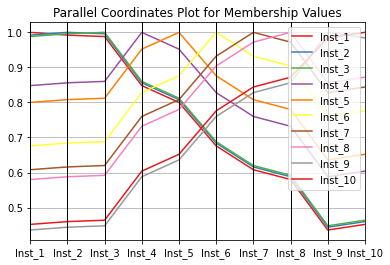


Membership Values for Feature IF:


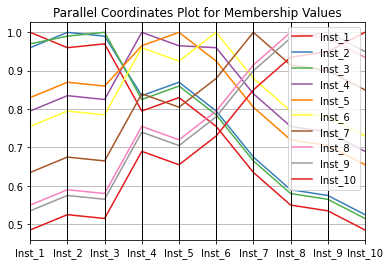


Membership Values for Feature PP:


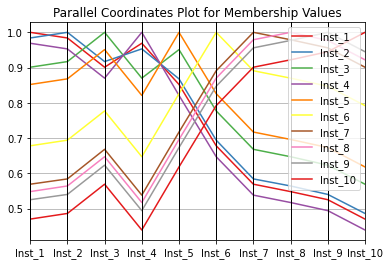


Membership Values for Feature RS:


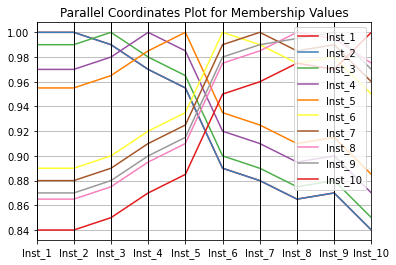


Membership Values for Feature SS:


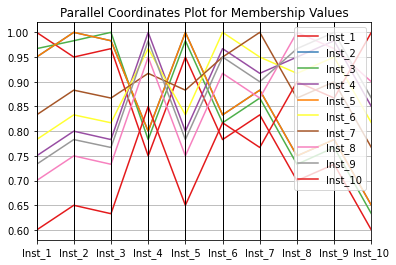


Membership Values for Feature ECA:


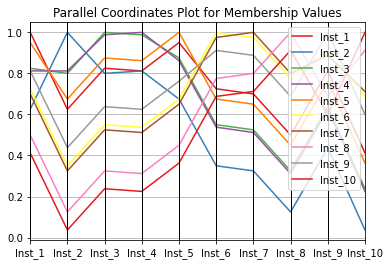

In [8]:
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
for feature, membership_df in membership_values.items():
    print(f"\nMembership Values for Feature {feature}:")
    membership_df['Institution'] = membership_df.index
    parallel_coordinates(membership_df, 'Institution', color=plt.cm.Set1.colors)
    plt.title(f'Parallel Coordinates Plot for Membership Values')
    plt.show()




# Final Table with Z and C values

In [9]:
print(Z_table)

           IC    IF    PP    RS    SS   ECA  C_value
Inst_1   0.91  0.73  0.80  0.77  0.90  0.64     4.74
Inst_2   0.91  0.73  0.80  0.77  0.90  0.99     5.10
Inst_3   0.91  0.73  0.67  0.77  0.90  0.79     4.77
Inst_4   0.74  0.55  0.80  0.77  0.69  0.79     4.34
Inst_5   0.74  0.55  0.67  0.77  0.90  0.64     4.26
Inst_6   0.54  0.55  0.47  0.77  0.69  0.32     3.34
Inst_7   0.54  0.39  0.32  0.77  0.69  0.32     3.03
Inst_8   0.54  0.28  0.32  0.77  0.69  0.11     2.71
Inst_9   0.36  0.28  0.32  0.77  0.69  0.42     2.84
Inst_10  0.36  0.28  0.32  0.77  0.53  0.02     2.28


# Weighted Final Table

In [10]:
print(Weighted_Z_table)

            IC     IF     PP     RS     SS    ECA  C_value  Weighted_C_value
Inst_1   0.909  0.732  0.795  0.771  0.900  0.638    4.745             0.788
Inst_2   0.909  0.732  0.795  0.771  0.900  0.988    5.095             0.788
Inst_3   0.909  0.732  0.666  0.771  0.900  0.794    4.772             0.730
Inst_4   0.740  0.548  0.795  0.771  0.693  0.794    4.341             0.733
Inst_5   0.740  0.548  0.666  0.771  0.900  0.638    4.263             0.695
Inst_6   0.537  0.548  0.468  0.771  0.693  0.325    3.342             0.544
Inst_7   0.537  0.390  0.318  0.771  0.693  0.325    3.034             0.476
Inst_8   0.537  0.278  0.318  0.771  0.693  0.112    2.709             0.475
Inst_9   0.360  0.278  0.318  0.771  0.693  0.425    2.845             0.440
Inst_10  0.360  0.278  0.318  0.771  0.533  0.025    2.285             0.424


In [11]:
print(f"\n\nThe best institution based on C value: {', '.join(best_institutions)} with C value = {max_C_value}")
print(f"\nThe best institution based on Weighted C value: {', '.join(best_weighted_institutions)} with Weighted C value = {max_weighted_C_value}\n")



The best institution based on C value: Inst_2 with C value = 5.1

The best institution based on Weighted C value: Inst_1, Inst_2 with Weighted C value = 0.788

